## Scraping wikipedia tables with python selectively


Use this Notebook to build the code to scrape the Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe

In [1]:
# importing the needed library

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup


In [2]:
# define the dataframe columns
column_names = ['Postcode', 'Borough', 'Neighbourhood'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [3]:
# Use the data from Wikipedia

Postcode = pd.DataFrame()
Borough = pd.DataFrame()
Neighbourhood = pd.DataFrame()

URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

res = requests.get(URL).text
soup = BeautifulSoup(res,'lxml')
for items in soup.find('table', class_='wikitable').find_all('tr')[1::1]:
    data = items.find_all(['th','td'])
    try:
        Postcode = np.append(Postcode, data[0].text)
        
        Borough = np.append(Borough, data[1].text)
       
        Neighbourhood = np.append(Neighbourhood, data[2].text)
       
    except IndexError:pass
   

In [4]:
# Fill up the array
neighborhoods['Postcode'] = Postcode 
neighborhoods[ 'Borough'] = Borough
neighborhoods[ 'Neighbourhood'] = Neighbourhood

In [5]:
# Ignore cells with a borough that is Not assigned.
neighborhoods = neighborhoods[neighborhoods.Borough != 'Not assigned']
#Remove '\n' in text in Neighbourhood
neighborhoods['Neighbourhood'].replace(r'\n', '', regex=True, inplace=True) 
#  PostalCode with two neighborhoods rows will be combined into one row with the neighborhoods separated with a comma
neighborhoods= neighborhoods.groupby(neighborhoods['Postcode'],
                                     sort=False).agg({"Borough": 'first', "Neighbourhood":', '.join}).reset_index()
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
neighborhoods['Neighbourhood'] = np.where(neighborhoods['Neighbourhood'] == 'Not assigned',
                                          neighborhoods['Borough'], neighborhoods['Neighbourhood'])



In [6]:
# Read the csv file that has the geographical coordinates of each postal code
g = pd.read_csv('Geospatial_Coordinates.csv')

In [7]:
# change column name for easy mege
g = g.rename(columns={"Postal Code": "Postcode"})

In [8]:
# Use the Geocoder package or the csv file to create the following dataframe:
neighborhoods = pd.DataFrame.merge(neighborhoods,g,on='Postcode')

In [10]:
neighborhoods.head(3)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636


## Explore and cluster the neighborhoods in Toronto

In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


In [27]:
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

### Use geopy library to get the latitude and longitude values of Toronto

In [51]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [189]:
# create map of Toronto using latitude and longitude values

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

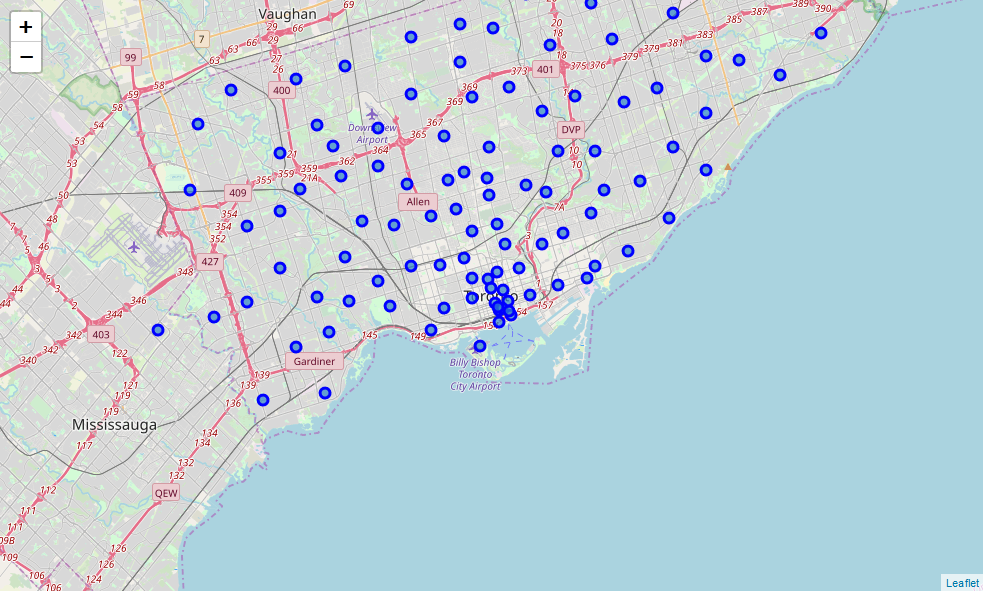

In [55]:
results = requests.get(url).json()

In [56]:
results

{'meta': {'code': 200, 'requestId': '5dc69194bbed2100389a3dac'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 80,
  'suggestedBounds': {'ne': {'lat': 43.6584630045, 'lng': -79.38099903084075},
   'sw': {'lat': 43.649462995499995, 'lng': -79.39341496915925}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
          

In [57]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [58]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Cafe Plenty,Café,43.654571,-79.389450
3,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501
4,Rolltation,Japanese Restaurant,43.654918,-79.387424


In [59]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

80 venues were returned by Foursquare.


### Explore Neighborhoods in Toronto

In [60]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [61]:
toronto_venues = getNearbyVenues(names=neighborhoods['Neighbourhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Heights, Lawrence Manor
Queen's Park
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The D

 __Let's check the size of the resulting dataframe__

In [62]:
print(toronto_venues.shape)
toronto_venues.head()

(2233, 7)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [63]:
toronto_venues.groupby('Neighbourhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",7,7,7,7,7,7
"Alderwood, Long Branch",9,9,9,9,9,9
...,...,...,...,...,...,...
Willowdale West,7,7,7,7,7,7
Woburn,3,3,3,3,3,3
"Woodbine Gardens, Parkview Hill",14,14,14,14,14,14


__Let's find out how many unique categories can be curated from all the returned venues__

In [64]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


## Analyze Each Neighborhood

In [65]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
manhattan_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Parkwoods
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Parkwoods
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village


And let's examine the new dataframe size.


In [66]:
toronto_onehot.shape

(2233, 275)

__Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category__

In [67]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,...,0.0,0.02,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
97,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
98,"Woodbine Gardens, Parkview Hill",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
99,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.090909,0.0,0.0,0.00,0.0,0.0,0.0


__Let's confirm the new size__

In [68]:
toronto_grouped.shape

(101, 275)

__Let's print each neighborhood along with the top 5 most common venues__

In [70]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [151]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Cosmetics Shop,American Restaurant,Hotel,Restaurant,Steakhouse,Bakery,Asian Restaurant
1,Agincourt,Clothing Store,Breakfast Spot,Lounge,Latin American Restaurant,Yoga Studio,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Yoga Studio,Empanada Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pharmacy,Grocery Store,Beer Store,Sandwich Place,Fried Chicken Joint,Fast Food Restaurant,Pizza Place,Construction & Landscaping,Concert Hall,Farmers Market
4,"Alderwood, Long Branch",Pizza Place,Pharmacy,Gym,Skating Rink,Sandwich Place,Coffee Shop,Pub,Pool,Drugstore,Discount Store


## Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [102]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [152]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0])

__Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.__

In [159]:
neighborhoods_venues_sorted

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,"Adelaide, King, Richmond",NaN,Café,Bar,Cosmetics Shop,American Restaurant,Hotel,Restaurant,Steakhouse,Bakery,Asian Restaurant
1,0,Agincourt,NaN,Breakfast Spot,Lounge,Latin American Restaurant,Yoga Studio,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
2,2,"Agincourt North, L'Amoreaux East, Milliken, St...",NaN,Park,Yoga Studio,Empanada Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
3,0,"Albion Gardens, Beaumond Heights, Humbergate, ...",NaN,Grocery Store,Beer Store,Sandwich Place,Fried Chicken Joint,Fast Food Restaurant,Pizza Place,Construction & Landscaping,Concert Hall,Farmers Market
4,0,"Alderwood, Long Branch",NaN,Pharmacy,Gym,Skating Rink,Sandwich Place,Coffee Shop,Pub,Pool,Drugstore,Discount Store
...,...,...,...,...,...,...,...,...,...,...,...,...
96,0,Willowdale West,NaN,Grocery Store,Butcher,Coffee Shop,Home Service,Discount Store,Pizza Place,Falafel Restaurant,Event Space,Ethiopian Restaurant
97,0,Woburn,NaN,Korean Restaurant,Yoga Studio,Empanada Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
98,0,"Woodbine Gardens, Parkview Hill",NaN,Pizza Place,Intersection,Athletics & Sports,Breakfast Spot,Café,Gastropub,Bus Line,Pharmacy,Gym / Fitness Center
99,0,Woodbine Heights,NaN,Curling Ice,Asian Restaurant,Pharmacy,Park,Cosmetics Shop,Video Store,Beer Store,Dance Studio,Athletics & Sports


In [156]:
toronto_merged.shape

(103, 16)

In [153]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Park,Food & Drink Shop,Yoga Studio,Empanada Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Intersection,Hockey Arena,Coffee Shop,Portuguese Restaurant,Financial or Legal Service,Pizza Place,Cosmetics Shop,Dog Run,Field,Fast Food Restaurant
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Pub,Park,Theater,Breakfast Spot,Café,Mexican Restaurant,Yoga Studio,Shoe Store
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,0.0,Clothing Store,Accessories Store,Arts & Crafts Store,Furniture / Home Store,Fraternity House,Event Space,Miscellaneous Shop,Coffee Shop,Boutique,Athletics & Sports
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,0.0,Coffee Shop,Park,Gym,Diner,Chinese Restaurant,Smoothie Shop,Seafood Restaurant,Sandwich Place,Burger Joint,Burrito Place


In [187]:
toronto_merged = toronto_merged.dropna()

In [185]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype( 'int32')

Finally, let's visualize the resulting clusters


In [84]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [186]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
       
map_clusters

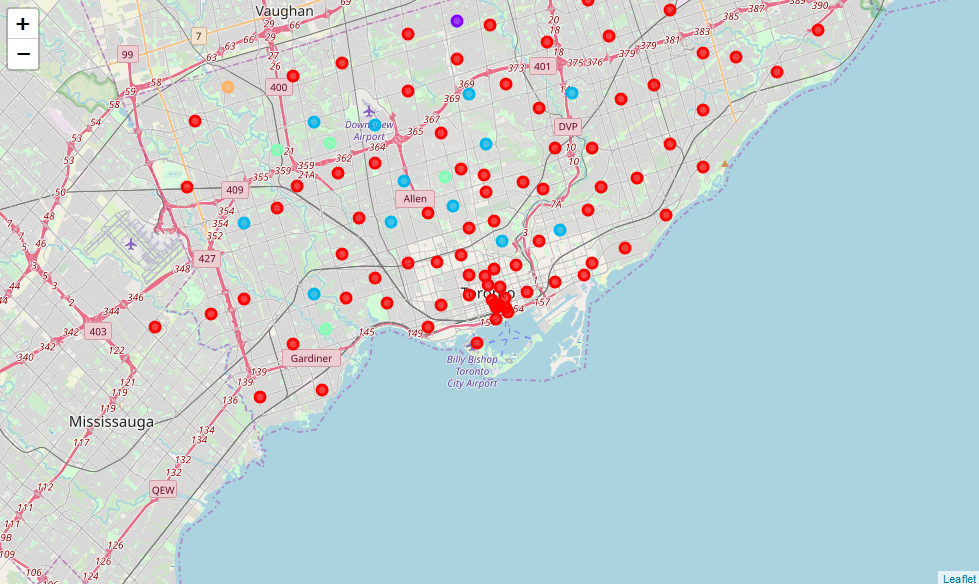